# Initialize notebook

In [1]:
import wandb

In [2]:
import lpips
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset

In [3]:
import sys
sys.path.append("/home/e/e0425222/CS4243-project")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import visualize_results, sample_batch, summary
from utils.train_utils.model_utils import Conv2dBlock, GatedConv2dBlock, GatedUpConv2dBlock

/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
train_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_train.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

valid_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_val.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

test_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_test.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])


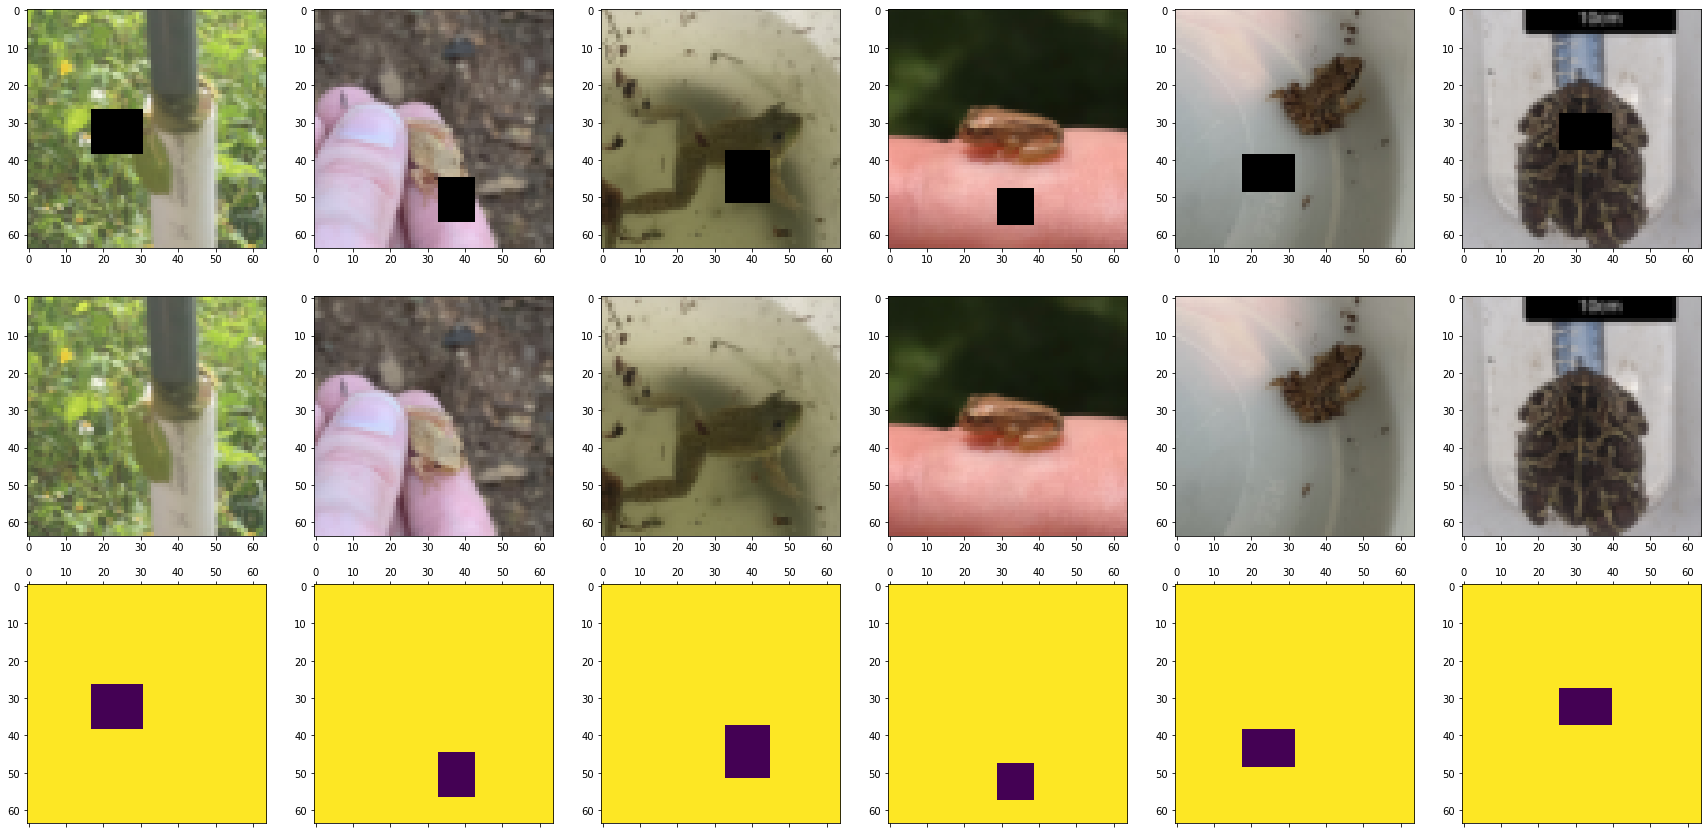

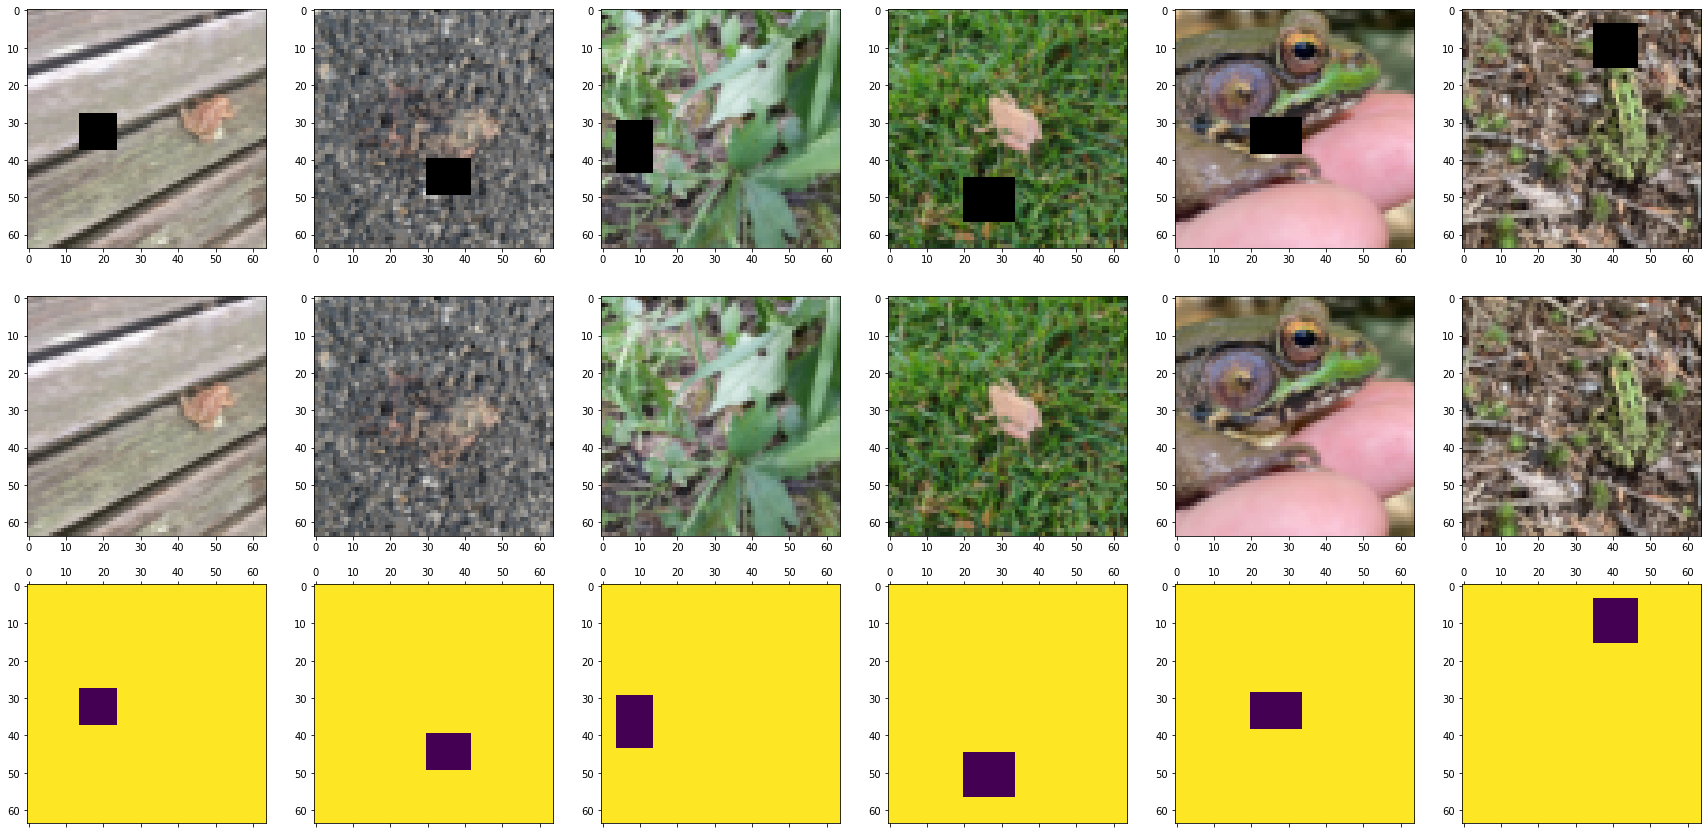

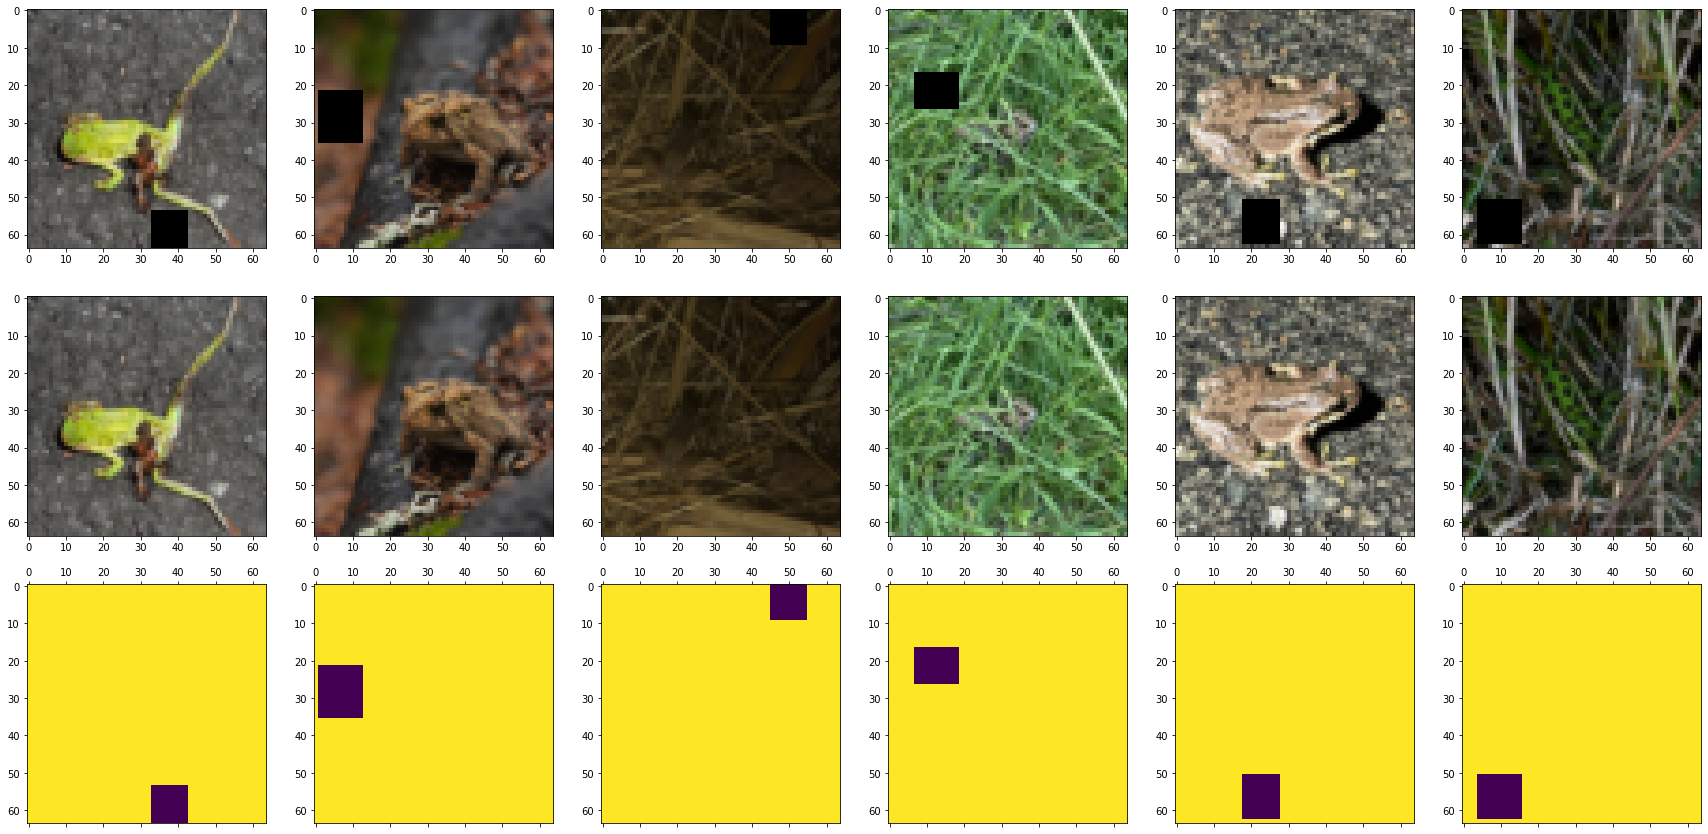

In [5]:
# sanity check 
sample_batch(train_dataset, sample_size = 6)
sample_batch(valid_dataset, sample_size = 6)
sample_batch(test_dataset, sample_size = 6)


# Introduction
This notebook aims to explore how contrastive learning can improve GAN performance for image inpainting. References are: 
1. Siamese Neural Networks for One-shot Image Recognition
2. SiGAN: Siamese Generative Adversarial Network for Identity-Preserving Face Hallucination
3. Free-Form Image Inpainting via Contrastive Attention Network

# Model experiment


In [6]:
class Generator(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(Generator, self).__init__()
        
        # same -> downsample -> same -> downsample
        self.conv0 = GatedConv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv1 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv3 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # 2 x same conv
        self.conv4 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv5 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # 4 x dilated conv
        self.conv6 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 2, dilation = 2, activation = activation)
        self.conv7 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 4, dilation = 4, activation = activation)
        self.conv8 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 8, dilation = 8, activation = activation)
        self.conv9 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 16, dilation = 16, activation = activation)

        # 2 x same conv
        self.conv10 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv11 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # upsample -> same -> upsample -> same
        self.conv12 = GatedUpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')
        self.conv13 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv14 = GatedUpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')
        self.conv15 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # final
        self.final = nn.Conv2d(hidden_dim, output_dim, kernel_size = 3, stride = 1, padding = 'same')

        # for contrastive learning, 1x1 conv to compress feature map into 1 channel
        self.conv_feature = nn.Conv2d(hidden_dim, 1, kernel_size = 1, stride = 1, padding = 'same')

    def forward(self, input_tensor):

        x = self.conv0(input_tensor)
        
        # downsample
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # middle layers
        x = self.conv4(x) + x
        x = self.conv5(x) + x

        # dilated conv with residual skips
        x = self.conv6(x) + x
        x = self.conv7(x) + x
        x = self.conv8(x) + x
        x = self.conv9(x) + x

        # extract for contrastive loss
        x_feature = self.conv_feature(x)

        # middle layers
        x = self.conv10(x) + x
        x = self.conv11(x) + x

        # upsample
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        
        # final
        x = self.final(x)

        return x, x_feature


class Discriminator(nn.Module):

    def __init__(self, input_dim, hidden_dim, input_shape, activation):

        super(Discriminator, self).__init__()

        # 5 layers down
        self.conv0 = Conv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv1 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv3 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv4 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # linear to predict classes
        LATENT_H = input_shape//(2**5)
        self.linear = nn.Linear(LATENT_H**2 * hidden_dim, 1)


    def forward(self, input_tensor):
        
        x = self.conv0(input_tensor)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # scores
        x = torch.flatten(x, start_dim = 1)
        x = self.linear(x)

        return x

# Training configuration

In [7]:
MODEL_PARAMS = {
    "description" : """
        Base structure same as the GLCIC model. Gated convolutions replace all convolutions in the generator, 
        and a 1x1 convolution is used to flatten the output of the 4th dilated convolution layer. 
        This is the latent vector used for contrastive learning.""",
    "hidden_dim" : 64,
    "activation" : nn.Mish,
}

SAVE_PATHS = {
    "generator1" : "/home/e/e0425222/CS4243-project/active_experiments/final/ContrastiveGAN/generator1/generator1",
    "generator2" : "/home/e/e0425222/CS4243-project/active_experiments/final/ContrastiveGAN/generator2/generator2",
    "discriminator" : "/home/e/e0425222/CS4243-project/active_experiments/final/ContrastiveGAN/discriminator/discriminator"
}

TRAINING_PARAMS = {
    "num_epochs" : 20,
    "batch_size" : 64, 
    "learning_rate": 1e-4,
    "alpha": 1,
    "beta" : 0.01,
    "ADAM_betas" : (0.5, 0.999),
    "schedule_every" : 1,
    "sample_size" : 16,
    "log_every" : 10,
    "save_paths" : SAVE_PATHS,
}

LOGGING_CONFIG = {
    "model_params" : MODEL_PARAMS,
}
LOGGING_CONFIG.update(TRAINING_PARAMS)

# Experiment intialization

In [8]:
# 1. initialize model
generator1 = Generator(input_dim = 4, hidden_dim = MODEL_PARAMS["hidden_dim"], output_dim = 3, activation = MODEL_PARAMS["activation"])
generator2 = Generator(input_dim = 4, hidden_dim = MODEL_PARAMS["hidden_dim"], output_dim = 3, activation = MODEL_PARAMS["activation"])
discriminator = Discriminator(input_dim = 3, hidden_dim = MODEL_PARAMS["hidden_dim"], input_shape = 64, activation = MODEL_PARAMS["activation"])

summary(generator1)
summary(generator2)
summary(discriminator)

# 2. device
parallel = True
device = 'cuda:0'  
devices = [0,1,2,3]

if not parallel:
    generator1 = generator1.to(device)
    generator2 = generator2.to(device)
    discriminator = discriminator.to(device)
else:
    generator1 = nn.DataParallel(generator1, device_ids = devices)
    generator2 = nn.DataParallel(generator2, device_ids = devices)
    discriminator = nn.DataParallel(discriminator, device_ids = devices)

# 3. initialize loss functions
recon_loss_function = lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum()
contrastive_loss_function_same = lambda x1, x2 : nn.functional.mse_loss(x1, x2)
discriminator_loss_function = nn.functional.binary_cross_entropy_with_logits

# 4. initialize metrics
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)
METRICS = {
    "Peak SnR (Whole)" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img * (1-mask) + gt * mask, gt),
    "L2 loss (Whole)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask) + gt * mask, gt),
    "L2 loss (Mask)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "L1 loss (Whole)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask) + gt * mask, gt),
    "L1 loss (Mask)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "LPIPS (Whole)" : (lambda img, gt, mask : VGG_LPIPS(img * (1-mask) + gt * mask, gt).mean()),
}


# 5. initialize optimizers
generator1_optimizer = torch.optim.Adam(generator1.parameters(), lr = TRAINING_PARAMS["learning_rate"], betas = TRAINING_PARAMS["ADAM_betas"])
generator1_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator1_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

generator2_optimizer = torch.optim.Adam(generator2.parameters(), lr = TRAINING_PARAMS["learning_rate"], betas = TRAINING_PARAMS["ADAM_betas"])
generator2_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator2_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = TRAINING_PARAMS["learning_rate"], betas = TRAINING_PARAMS["ADAM_betas"])
discriminator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# 6. wrap into training dictionary
TRAINING_PARAMS["generator1_model"] = generator1
TRAINING_PARAMS["generator1_optimizer"] = generator1_optimizer
TRAINING_PARAMS["generator1_scheduler"] = generator1_scheduler
TRAINING_PARAMS["generator2_model"] = generator2
TRAINING_PARAMS["generator2_optimizer"] = generator2_optimizer
TRAINING_PARAMS["generator2_scheduler"] = generator2_scheduler
TRAINING_PARAMS["discriminator_model"] = discriminator
TRAINING_PARAMS["discriminator_optimizer"] = discriminator_optimizer
TRAINING_PARAMS["discriminator_scheduler"] = discriminator_scheduler
TRAINING_PARAMS["discriminator_loss_function"] = discriminator_loss_function
TRAINING_PARAMS["contrastive_loss_function"] = contrastive_loss_function_same
TRAINING_PARAMS["recon_loss_function"] = recon_loss_function



model has 1.11642 million parameters
model has 1.11642 million parameters
model has 0.150401 million parameters
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


# Intialize logging

In [9]:
wandb.init(project="final", entity="cs4243_project")
wandb.config = LOGGING_CONFIG

wandb.watch(
    (generator1, generator2, discriminator),
    criterion = None,
    log = 'all',
    log_freq = 1,
    idx = 0, 
    log_graph = False
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanyjnaaman (use `wandb login --relogin` to force relogin)


[]

# Train

## Train functions

In [10]:

def train_epoch(device, train_dataloader, training_params : dict, metrics : dict, log_wandb = True):
    
    # ===== INITIALIZE =====
    # constants
    RECONSTRUCTION_LOSS = training_params["recon_loss_function"]
    DISCRIMINATOR_LOSS_FUNCTION = training_params["discriminator_loss_function"]
    CONTRASTIVE_LOSS_FUNCTION = training_params["contrastive_loss_function"]

    GENERATOR1_OPTIMIZER = training_params["generator1_optimizer"]
    GENERATOR2_OPTIMIZER = training_params["generator2_optimizer"]
    DISCRIMINATOR_OPTIMIZER = training_params["discriminator_optimizer"]

    BATCH_EVALUATE_EVERY = 5
    LOG_EVERY = training_params["log_every"]
    SAMPLE_SIZE = training_params["sample_size"]
    BATCH_SIZE = training_params["batch_size"]
    ALPHA = training_params["alpha"]
    BETA = training_params["beta"]

    # models
    generator1 = training_params["generator1_model"].to(device).train()
    generator2 = training_params["generator2_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss_discriminator"] = 0.0
    running_results["loss_generator1"] = 0.0
    running_results["loss_generator1_r"] = 0.0
    running_results["loss_generator1_adv"] = 0.0
    running_results["loss_generator2"] = 0.0
    running_results["loss_generator2_r"] = 0.0
    running_results["loss_generator2_adv"] = 0.0
    running_results["loss_contrastive"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for _, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # set the gradients to zeros
            GENERATOR1_OPTIMIZER.zero_grad()
            GENERATOR2_OPTIMIZER.zero_grad()
            DISCRIMINATOR_OPTIMIZER.zero_grad()

            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # ===== FORWARD PASS =====

            # 1. train discriminator
            
            # 1.1 generate images
            input_batched.requires_grad_()
            output1_batched, _ = generator1(input_batched)
            shuffled_indices = torch.randperm(n = BATCH_SIZE)
            output2_batched, _ = generator2(input_batched[shuffled_indices]) # random permutation

            # 1.2 splice with ground truth
            spliced1_batched = ((1-mask_batched) * output1_batched) + (mask_batched * ground_truth_batched) 
            spliced2_batched = ((1-mask_batched[shuffled_indices]) * output2_batched) + (mask_batched[shuffled_indices] * ground_truth_batched[shuffled_indices]) 

            # 1.3 feed into discriminator
            label_real = torch.ones(BATCH_SIZE * 2, 1).to(device)
            label_fake = torch.zeros(BATCH_SIZE * 2, 1).to(device)

            pred_real = discriminator(torch.cat([ground_truth_batched, ground_truth_batched[shuffled_indices]], dim = 0))
            loss_real = DISCRIMINATOR_LOSS_FUNCTION(pred_real, label_real)

            pred_fake = discriminator(torch.cat([spliced1_batched, spliced2_batched[shuffled_indices]], dim = 0).detach())
            loss_fake = DISCRIMINATOR_LOSS_FUNCTION(pred_fake, label_fake)
            loss_d = ALPHA * (loss_real + loss_fake)
            loss_d.backward()
            DISCRIMINATOR_OPTIMIZER.step()

            # 2. train generator 1 (reconstruction, adverserial, contrastive)
            GENERATOR1_OPTIMIZER.zero_grad()

            # 2.1 forward pass by generator to produce images, splice them
            output1_batched, _ = generator1(input_batched)
            spliced1_batched = ((1-mask_batched) * output1_batched) + (mask_batched * ground_truth_batched) 
            
            # 2.2 reconstruction loss
            loss_g1_reconstruction = RECONSTRUCTION_LOSS(output1_batched, ground_truth_batched, mask_batched)

            # 2.3 adverserial loss
            label_real = torch.ones(BATCH_SIZE, 1).to(device)
            pred1_adverserial = discriminator(spliced1_batched)
            loss_g1_adverserial = DISCRIMINATOR_LOSS_FUNCTION(pred1_adverserial, label_real) # want it to classify all as real

            # 2.4 contrastive loss
            shuffled_indices = torch.randperm(n = BATCH_SIZE)
            copied_input_batched = torch.cat([ground_truth_batched * mask_batched[shuffled_indices], mask_batched[shuffled_indices]], dim = 1)
            _, x1 = generator1(input_batched)
            _, x2 = generator2(copied_input_batched.detach()) # same image, different masks
            loss_contrastive1 = CONTRASTIVE_LOSS_FUNCTION(x1, x2)

            # 2.5 backprop
            loss_g1 = loss_g1_reconstruction + ALPHA * loss_g1_adverserial + BETA * loss_contrastive1
            loss_g1.backward()
            GENERATOR1_OPTIMIZER.step()

            # 3.  train generator 2 (reconstruction, adverserial, contrastive)
            GENERATOR2_OPTIMIZER.zero_grad()

            # 3.1 forward pass by generator to produce images, reconstruction loss
            output2_batched, _ = generator2(input_batched)
            spliced2_batched = ((1-mask_batched) * output2_batched) + (mask_batched * ground_truth_batched) 
            loss_g2_reconstruction = RECONSTRUCTION_LOSS(output2_batched, ground_truth_batched, mask_batched)

            # 3.2 adverserial loss
            label_real = torch.ones(BATCH_SIZE, 1).to(device)
            pred2_adverserial = discriminator(spliced2_batched)
            loss_g2_adverserial = DISCRIMINATOR_LOSS_FUNCTION(pred2_adverserial, label_real) # want it to classify all as real

            # 3.3 contrastive loss
            shuffled_indices = torch.randperm(n = BATCH_SIZE)
            copied_input_batched = torch.cat([ground_truth_batched * mask_batched[shuffled_indices], mask_batched[shuffled_indices]], dim = 1)
            _, x1 = generator1(input_batched.detach())
            _, x2 = generator2(copied_input_batched) # same image, different masks
            loss_contrastive2 = CONTRASTIVE_LOSS_FUNCTION(x1, x2)

            # 3.4 backprop
            loss_g2 = loss_g2_reconstruction + ALPHA * loss_g2_adverserial + BETA * loss_contrastive2
            loss_g2.backward()
            GENERATOR2_OPTIMIZER.step()


            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # 1. compute losses

            running_results["loss_generator1"] += loss_g1.detach().item()
            running_results["loss_generator1_r"] += loss_g1_reconstruction.detach().item()
            running_results["loss_generator1_adv"] += loss_g1_adverserial.detach().item()
            running_results["loss_generator2"] += loss_g2.detach().item()
            running_results["loss_generator2_r"] += loss_g2_reconstruction.detach().item()
            running_results["loss_generator2_adv"] += loss_g2_adverserial.detach().item()
            running_results["loss_contrastive"] += (loss_contrastive1.detach().item() + loss_contrastive2.detach().item())/2
            running_results["loss_discriminator"] += loss_d.detach().item()

            # 2. for each key, compute, add item to results dictionary (take average of 2 generators)
            for key, func in metrics.items():
                res1 = func(output1_batched, ground_truth_batched, mask_batched).detach().item()
                res2 = func(output2_batched, ground_truth_batched, mask_batched).detach().item()
                running_results[key] += (res1 + res2)/2

            # 3. log with wandb
            if log_wandb and (num_batches % LOG_EVERY == 0):

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced1_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images1 = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                # generator 2
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced2_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images2 = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")

                # log images and some metadata
                wandb.log( {
                    "generator1_train_images" : images1,
                    "generator2_train_images" : images2,
                    "lr_generator1" : GENERATOR1_OPTIMIZER.param_groups[0]['lr'],
                    "lr_generator2" : GENERATOR2_OPTIMIZER.param_groups[0]['lr'],
                    "lr_discriminator" : DISCRIMINATOR_OPTIMIZER.param_groups[0]['lr']

                })

                # log all metrics
                wandb.log(
                    {key : item/num_batches for key, item in running_results.items()}
                )
        

            # ===== HOUSEKEEPING =====
            del loss_g2
            del loss_g1
            del loss_d
            del input_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, _ in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, val in running_results.items():
        running_results[key] /= num_batches

    return running_results




In [11]:
def evaluate_epoch(device, validation_dataloader, training_params : dict, metrics : dict, log_wandb = True):

    # ===== INITIALIZE =====
    # models
    generator1 = training_params["generator1_model"].to(device).eval()
    generator2 = training_params["generator2_model"].to(device).eval()

    # constants
    SAMPLE_SIZE = training_params["sample_size"]

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        batches = 0
        for index, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # ===== FORWARD PASS =====

            # 1. reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # 2. predict    
            output1_batched, _ = generator1(input_batched)
            output2_batched, _ = generator2(input_batched)           
            spliced1_batched = ((1-mask_batched) * output1_batched) + (mask_batched * ground_truth_batched) 
            spliced2_batched = ((1-mask_batched) * output2_batched) + (mask_batched * ground_truth_batched) 

            # 3. evaluate
            for key, func in metrics.items():
                running_results[key] += (func(output1_batched, ground_truth_batched, mask_batched).detach().item() + func(output2_batched, ground_truth_batched, mask_batched).detach().item())/2

            args = ""
            for key, val in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # 4. log 
            if log_wandb:

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced1_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images1 = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                # generator 2
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced2_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images2 = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")

                # log images and some metadata
                wandb.log( {
                    "generator1_val_images" : images1,
                    "generator2_val_images" : images2
                })

                # log all metrics
                wandb.log(
                    {f"eval_{key}" : item/batches for key, item in running_results.items()}
                )

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= batches

    return running_results


In [12]:
def train_evaluate(device, train_dataset, validation_dataset, training_params: dict, metrics: dict, start_epoch = 0, log_wandb = True):

    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    GENERATOR1_SCHEDULER = training_params["generator1_scheduler"]
    GENERATOR2_SCHEDULER = training_params["generator2_scheduler"]
    DISCRIMINATOR_SCHEDULER = training_params["discriminator_scheduler"]
    SAVE_PATHS = training_params["save_paths"]
    NUM_WORKERS = 2
    START_EPOCH = start_epoch

    # models for saving
    generator1 = training_params["generator1_model"].to(device).train()
    generator2 = training_params["generator2_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # variable losses
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    train_results["loss_discriminator"] = []
    train_results["loss_generator1"] = []
    train_results["loss_generator1_r"] = []
    train_results["loss_generator1_adv"] = []
    train_results["loss_generator2"] = []
    train_results["loss_generator2_r"] = []
    train_results["loss_generator2_adv"] = []
    train_results["loss_contrastive"] = []

    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")
        num_batches = 0

        # train every epoch
        results = train_epoch(device, train_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print()
        results = evaluate_epoch(device, validation_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if DISCRIMINATOR_SCHEDULER is not None:
            DISCRIMINATOR_SCHEDULER.step(eval_results["L2 loss (Mask)"][epoch])
        if GENERATOR1_SCHEDULER is not None:
            GENERATOR1_SCHEDULER.step(eval_results["L2 loss (Mask)"][epoch])
        if GENERATOR2_SCHEDULER is not None:
            GENERATOR2_SCHEDULER.step(eval_results["L2 loss (Mask)"][epoch])
            
        # save every epoch
        SAVE = f"{SAVE_PATHS['generator1']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(generator1.state_dict(), SAVE)
        SAVE = f"{SAVE_PATHS['generator2']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(generator2.state_dict(), SAVE)
        SAVE = f"{SAVE_PATHS['discriminator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(discriminator.state_dict(), SAVE)  

        print("Saved models!")

    return train_results, eval_results

## Train

In [14]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 1, log_wandb = True)


===== Epoch: 2 ===== 
75/78: Peak SnR (Whole): 31.053221079508464   L2 loss (Whole): 0.000786488561037307   L2 loss (Mask): 0.0683440222342809   L1 loss (Whole): 0.004017099519260227   L1 loss (Mask): 0.34909313400586445   LPIPS (Whole): 0.04020739967624346   loss_discriminator: 1.3880377435684204   loss_generator1: 0.7773072520891825   loss_generator1_r: 0.06930267289280892   loss_generator1_adv: 0.7001876465479533   loss_generator2: 0.7763390334447225   loss_generator2_r: 0.06738537157575289   loss_generator2_adv: 0.7011859170595804   loss_contrastive: 0.7792336130142212      
7/7: Peak SnR (Whole): 31.61581666128976   L2 loss (Whole): 0.000688454310875386   L2 loss (Mask): 0.05997761445386069   L1 loss (Whole): 0.0036734839003267033   L1 loss (Mask): 0.3200700410774776   LPIPS (Whole): 0.03733993135392666       
Completed epoch 2! Took 7.490774023532867 min
Saved models!

===== Epoch: 3 ===== 
75/78: Peak SnR (Whole): 31.53795088450114   L2 loss (Whole): 0.000703055172925815   L2 l

wandb: Network error (ReadTimeout), entering retry loop.


75/78: Peak SnR (Whole): 32.26210015614827   L2 loss (Whole): 0.0005947343452135101   L2 loss (Mask): 0.05168715725342433   L1 loss (Whole): 0.003413037322461605   L1 loss (Mask): 0.29659635583559674   LPIPS (Whole): 0.035183315599958104   loss_discriminator: 1.3783173418045045   loss_generator1: 0.7609235588709513   loss_generator1_r: 0.05022897352774938   loss_generator1_adv: 0.7087512882550557   loss_generator2: 0.7610900521278381   loss_generator2_r: 0.05314534097909927   loss_generator2_adv: 0.7060032002131145   loss_contrastive: 0.19424007912476857     
7/7: Peak SnR (Whole): 31.63477107456752   L2 loss (Whole): 0.000692261428672022   L2 loss (Mask): 0.06024887013648238   L1 loss (Whole): 0.003698235693653779   L1 loss (Mask): 0.32186881984983173   LPIPS (Whole): 0.03428096244377749       
Completed epoch 8! Took 7.252067629496256 min
Saved models!

===== Epoch: 9 ===== 
75/78: Peak SnR (Whole): 31.844848721822103   L2 loss (Whole): 0.00066161370719783   L2 loss (Mask): 0.0574646

({'Peak SnR (Whole)': [31.07629694082798,
   31.54099600131695,
   31.74142354573959,
   31.966794197375958,
   32.141992030999596,
   32.24628580533541,
   32.2422726949056,
   31.853945389772072,
   31.934785830668915,
   32.100846009376724,
   32.12058888948881,
   32.09061549260066,
   32.04313254967714,
   32.106140919220756,
   32.127917106334976,
   32.170962712703606,
   32.22692040908031,
   32.162476539611816,
   32.18125166037144,
   32.23796091324244],
  'L2 loss (Whole)': [0.0007826849763753274,
   0.0007026147728678412,
   0.0006707566062686965,
   0.0006377386587421194,
   0.0006112944310865341,
   0.0005980033478968275,
   0.0005977844257125607,
   0.000660554027537075,
   0.0006508832920166568,
   0.0006238087724061467,
   0.00062015943153827,
   0.0006226114210454771,
   0.0006288470103754662,
   0.0006198163003621934,
   0.0006168232435951582,
   0.0006105757884842416,
   0.0006020479534830278,
   0.0006113008956815928,
   0.0006086140511354479,
   0.0006006890598189

In [15]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 20, log_wandb = True)


===== Epoch: 21 ===== 
75/78: Peak SnR (Whole): 32.214335695902506   L2 loss (Whole): 0.0006047969032078981   L2 loss (Mask): 0.05226198874413967   L1 loss (Whole): 0.003362886180790762   L1 loss (Mask): 0.29060394525527955   LPIPS (Whole): 0.02732614876081546   loss_discriminator: 1.3858202171325684   loss_generator1: 0.7542617424329122   loss_generator1_r: 0.04675613224506378   loss_generator1_adv: 0.7063720750808716   loss_generator2: 0.7502306461334228   loss_generator2_r: 0.057767845243215564   loss_generator2_adv: 0.6913300387064616   loss_contrastive: 0.11331483865777651    
7/7: Peak SnR (Whole): 32.07830442701067   L2 loss (Whole): 0.0006225824430917523   L2 loss (Mask): 0.053872639047248025   L1 loss (Whole): 0.003375192588594343   L1 loss (Mask): 0.29202646017074585   LPIPS (Whole): 0.02694969411407198    
Completed epoch 21! Took 6.7669264833132425 min
Saved models!

===== Epoch: 22 ===== 
75/78: Peak SnR (Whole): 32.260791575113934   L2 loss (Whole): 0.0005978947062976658

wandb: Network error (ReadTimeout), entering retry loop.


75/78: Peak SnR (Whole): 32.24419242858887   L2 loss (Whole): 0.0005990895378636197   L2 loss (Mask): 0.051935738921165465   L1 loss (Whole): 0.0033435704139992595   L1 loss (Mask): 0.28984654307365415   LPIPS (Whole): 0.027177320110301176   loss_discriminator: 1.38577227751414   loss_generator1: 0.7533999077479044   loss_generator1_r: 0.046686159471670784   loss_generator1_adv: 0.7056055323282877   loss_generator2: 0.7500749675432841   loss_generator2_r: 0.05718531837066015   loss_generator2_adv: 0.6917836054166158   loss_contrastive: 0.1107127958536148   
7/7: Peak SnR (Whole): 32.195044245038716   L2 loss (Whole): 0.0006063271097705833   L2 loss (Mask): 0.05260047689080238   L1 loss (Whole): 0.003326798672787845   L1 loss (Mask): 0.28865477229867664   LPIPS (Whole): 0.02608058721359287    
Completed epoch 40! Took 7.264973791440328 min
Saved models!


({'Peak SnR (Whole)': [32.20660394277328,
   32.2516281299102,
   32.24255899282602,
   32.18851964901655,
   32.246533491672615,
   32.24667958724193,
   32.262376540746445,
   32.24747612537482,
   32.22424969306359,
   32.276168725429436,
   32.24899147718381,
   32.22631267400888,
   32.19822640296741,
   32.23678184166933,
   32.27269445321499,
   32.24756436470227,
   32.2374180769309,
   32.26744555204343,
   32.223959873884155,
   32.24333699544271],
  'L2 loss (Whole)': [0.0006058968742413876,
   0.0005991485862371823,
   0.0006003226091986737,
   0.0006071376940384746,
   0.0005995195210860588,
   0.0005997231568565043,
   0.000596708832092237,
   0.000599208680796437,
   0.0006027868782835774,
   0.0005960935177893426,
   0.0005991302023176104,
   0.0006019360134348226,
   0.0006060125184982704,
   0.0006003852369105563,
   0.0005958349343601208,
   0.0005991744134613933,
   0.0006000962140462481,
   0.0005965925016565821,
   0.000601875293516339,
   0.0005991830789403488],


In [ ]:
# train_epoch(device, DataLoader(train_dataset, batch_size = 16), TRAINING_PARAMS, METRICS, log_wandb = True)
# evaluate_epoch(device, DataLoader(valid_dataset, batch_size = 16),, TRAINING_PARAMS, metrics, log_wandb = True)